# Estimación de peso y dimensiones de los envíos de Mercado Libre

Este notebook es una versión mínima y necesaria para poder levantar el dataset [meli_dataset_20190426.csv](https://drive.google.com/open?id=1tNUKD1lf1z8C7LPpCruiDl6SKBAHb79v) y comprender los features que éste contiene.

# Sobre el dataset
El dataset corresponde a un muestreo de envíos durante tres meses de 2018 en MLB (Mercado Libre Brasil), filtrados según métodos de envíos y por carriers (empresas de correos a cargo del envío propiamente dicho). A su vez, fue muestreado de forma no uniforme para romper de forma manual la distribución de los datos.

In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy
import seaborn
import scipy as sc

In [ ]:
random.seed(0)

In [ ]:
DATASET = 'meli_dataset_20190426.csv'

In [ ]:
df = pd.read_csv(DATASET, low_memory=False)

In [ ]:
df.columns

#### ¿Qué significa cada columna?

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.

In [ ]:
df.sample(5)

In [ ]:
df = df.dropna(subset=['SHP_WEIGHT'])
df = df.dropna(subset=['SHP_LENGTH'])
df = df.dropna(subset=['SHP_WIDTH'])
df = df.dropna(subset=['SHP_HEIGHT'])
df = df.dropna(subset=['PRICE'])
df.sample(3)


El objetivo del análisis es predecir el peso y tamaño de los artículos. A su vez el tamaño se puede descomponer en largo, altura y ancho.  Las cuatro variables a predecir son numéricas continuas .
Probablemente la variable explicativa más importante sea DOMAIN_ID y ATTRIBUTES, dado que si se conoce el peso y tamaño de un artículo, los próximos envíos deberían tener las mismas características. En el caso de atributes, hay que preprocesar los datos para poder extraer algo de información.

Luego se dispone de otras variables complementarias, cuya incorporación podría incrementar el poder predictivo del modelo: CONDITION, STATUS, PRICE, SELLER_ID.

En primer lugar es conveniente relizar un análisis descriptivo, principalmente de las variables que se desea predecir.

## Analisis estadístico descriptivo de las variables peso, largo, altura y ancho

In [ ]:
df[['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', "SHP_HEIGHT", "PRICE"]].describe()

In [ ]:
#plt.figure(figsize=(17,5))
#seaborn.jointplot(data=df,
 #                 x='SHP_WEIGHT', y='STATUS', kind='hex')
#seaborn.despine()

In [ ]:
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_WEIGHT", data=df, palette="coolwarm")
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_LENGTH", data=df, palette="coolwarm")
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_WIDTH", data=df, palette="coolwarm")
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_HEIGHT", data=df, palette="coolwarm")
plt.figure(figsize=(14,2))
seaborn.boxplot(x="PRICE", data=df, palette="coolwarm")

In [ ]:
ku = sc.stats.kurtosis(df["SHP_WEIGHT"])
print('Kurtosis de SHP_WEIGHT: {}'.format(ku))
sw = sc.stats.skew(df["SHP_WEIGHT"])
print('Swewness de SHP_WEIGHT: {}'.format(sw))

In [ ]:
ku = sc.stats.kurtosis(df["SHP_LENGTH"])
print('Kurtosis de SHP_LENGTH: {}'.format(ku))
sw = sc.stats.skew(df["SHP_LENGTH"])
print('Swewness de SHP_LENGTH: {}'.format(sw))

In [ ]:
ku = sc.stats.kurtosis(df["SHP_WIDTH"])
print('Kurtosis de SHP_WIDTH: {}'.format(ku))
sw = sc.stats.skew(df["SHP_WIDTH"])
print('Swewness de SHP_WIDTH: {}'.format(sw))

In [ ]:
ku = sc.stats.kurtosis(df["SHP_HEIGHT"])
print('Kurtosis de SHP_HEIGHT: {}'.format(ku))
sw = sc.stats.skew(df["SHP_HEIGHT"])
print('Swewness de SHP_HEIGHT: {}'.format(sw))

In [ ]:
ku = sc.stats.kurtosis(df["PRICE"])
print('Kurtosis de PRICE: {}'.format(ku))
sw = sc.stats.skew(df["PRICE"])
print('Swewness de PRICE: {}'.format(sw))

In [ ]:
plt.figure(figsize=(8, 5))
seaborn.distplot(df['SHP_WEIGHT'], label='SHP_WEIGHT')
seaborn.despine()

In [ ]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['SHP_WIDTH'], label='SHP_WIDTH')
seaborn.despine()

In [ ]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['SHP_LENGTH'], label='SHP_LENGTH')
seaborn.despine()

In [ ]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['SHP_HEIGHT'], label='SHP_HEIGHT')
seaborn.despine()

C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


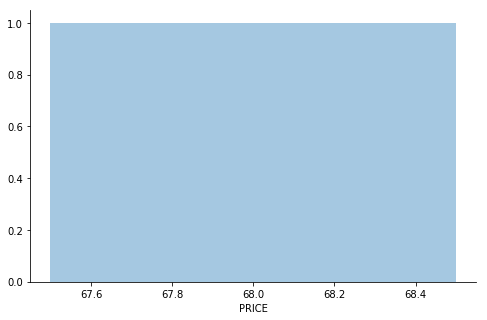

In [40]:
plt.figure(figsize=(8,5))
seaborn.distplot(df['PRICE'], label='PRICE')
seaborn.despine()

In [41]:
pd.value_counts(df['CONDITION'])

new    1
Name: CONDITION, dtype: int64

In [42]:
pd.value_counts(df['STATUS'])

active    1
Name: STATUS, dtype: int64

In [43]:
pd.value_counts(df['DOMAIN_ID'])

MLB-SKIN_CARE_SUPPLIES    1
Name: DOMAIN_ID, dtype: int64

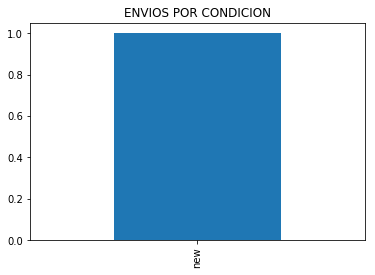

In [44]:
plot = df['CONDITION'].value_counts().plot(kind='bar',
                                            title='ENVIOS POR CONDICION')

En los envíos por condición la categoria modal es nuevo como refleja el gráfico, superando ampliamente las demás categorías

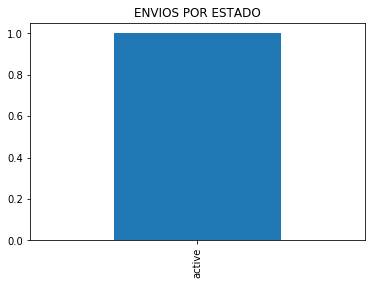

In [45]:
plot = df['STATUS'].value_counts().plot(kind='bar',
                                            title='ENVIOS POR ESTADO')

En los envíos por estado la categoria mas frecuente es activo

## ¿Qué criterios les parece mejor para limpiar el dataset de datos faltantes?

Los datos o el conjunto de datos del que disponemos a menudo no están completos para ser analizados apropiadamente.
La limpieza de los datos consiste en reemplazarlos o eliminarlos de una forma tal que, el resultado final se vea afectado lo menos posible.
Criterios que se podrían considerar para la limpieza:
- Eliminar registros con datos faltantes, eliminado filas con 1 dato faltante, campos nulos que superen una cantidad, o ciertos campos nulos no permitidos
- Reemplazar los valores faltantes con un dato que podría ser, la media, la mediana o la moda de acuerdo al tipo de distribución que tienen los datos
- Comparar los resultados para analizar el impacto considerando ambas alternativas

Para nuestro caso el criterio elegido es eliminar los registros en los que falte alguna de las medidas de peso, precio y volumen.
Vamos a partir de datos completos y los registros que queden fuera del análisis pueden usarse a futuro para determinar Qué valor sería
acorde para completarlos.

## Conclusiones sobre las distribuciones de las variables a predecir


Se aprecia que las cuatro variables a predecir tienen distribuciones con asimetría izquierda bastante marcada, especialmente el peso de los productos. Adempas las cuatro distribuciones son leptocúrticas o sea mas puntiagudas de que la distribución normal. También puede decirse que las variables no tienen distribuciones tan heterogéneas como se podría esperar, pero sí presentan múltiples outliers.

In [47]:
df = df.head(50)

categorias = list(df['DOMAIN_ID'].unique())
cvs_list = []

for categoria in categorias:
    pesos = df['SHP_WEIGHT'][df['DOMAIN_ID'] == categoria]
    cf = pesos.std() / pesos.mean()
    cvs_list.append(cf)
   # print(categoria,  'Coef. Var:', cf)


print(df)
print(cvs_list)

#guardo en una lista todos los coeficientes, y el nombre de la categoria 
#ordenamos los 10 mas grandes por coeficiente y mostramos que son los mas heterogeneos

#ESTO TIENE Q SER PARA CADA VARIABLE DE PESO Y MEDIDAS

      ITEM_ID  SHP_WEIGHT  SHP_LENGTH  SHP_WIDTH  SHP_HEIGHT  \
1  SN7ISIGQ9J       235.0        25.0       25.0        10.0   

                                          ATTRIBUTES CATALOG_PRODUCT_ID  \
1  [{'id': 'BRAND', 'name': 'Marca', 'value_id': ...         H53U1H7Q5G   

  CONDITION               DOMAIN_ID  PRICE   SELLER_ID  STATUS  \
1       new  MLB-SKIN_CARE_SUPPLIES   68.0  QF4OJMYQ9Q  active   

                                               TITLE  
1  Ácido Hidroquinona 20%   30g + Sabonete Pré Pe...  
[nan]


In [48]:
## COMO TRATAR LOS OUTLIERS, SERGIO ANOTAR